## Homework 3: Mean Shift

Name: Stephen Spivack

netID: ss7726

**Due date:** April 6, 2022

The goal of the assignment is to implement the mean shift algorithm and use it for image segmentation. You should return the completed notebook, including answers and illustrations. 


**Part 1: mean shift on synthetic data**

* Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.
* Implement a function that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).  Plot $G(x)$ for $d=1$.
* Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.
* Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant). Test it on your synthetic data and visualize the results.
* Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point. Visualize your results.
* Modify the previous code by allowing for a "bandwidth vector" $h \in \mathbb R^d$ that defines a different scale for each dimension of the input (this is because for segmentation we will use a different bandwidth for space and color). Note that you should also modify the convergence and merging conditions to consider this non-isotropic scaling.
* Experiment with your code by changing the data distribution, the kernel, and and bandwidth vector.

**Part 2: mean shift for image segmentation**

* For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg` (download from <a href="https://drive.google.com/file/d/1mmzZaKOCsH6PEo4w6Y6plcgf-vbEJvoj/view?usp=sharing">here</a>), and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 
* Convert the (N,M,3) image into an (NM,5) matrix incuding color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?
* Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode. You can also try our algorithm on other (small) images.

**Import packages**

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
from skimage.color import rgb2lab,lab2rgb
import skimage.io

**Part 1: mean shift on synthetic data**

Generate a synthetic dataset of 100 2D points, containing 60 points sampled from a Gaussian distribution  of unit covariance centered in (0,0) and 40 points sampled from a Gaussian with unit covariance centered in (4,4). Visualize your data.

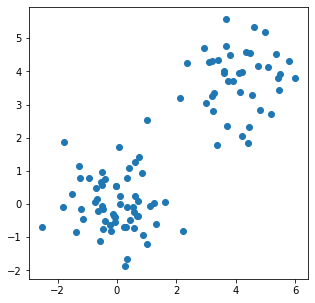

In [2]:
# Generate synthetic data:
x1 = np.random.normal(0,1,60)
y1 = np.random.normal(0,1,60)
x2 = np.random.normal(4,1,40)
y2 = np.random.normal(4,1,40)

# Concatenate the data:
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))

# Plot the data:
plt.figure(figsize=(5,5))
plt.plot(x,y,'o')
plt.show()

Implement a function `gaussian_kernel` that computes $G(x) = g(\|x\|^2/h^2)$ where $x \in \mathbb R^d$, $h$ is a bandwidth parameter and $g$ is the negative derivative of the Gaussian kernel or of the Epanechnikov kernel (see eq. 5.36 in Szeliski).

In [3]:
def euclidian_distance(x, xi):
    return np.sqrt(np.sum((x - xi)**2))
    
def gaussian_kernel(x, h):
    t = (x**2)/(h**2)
    return -np.exp(t/2)

Plot $G(x)$ for $d=1$.

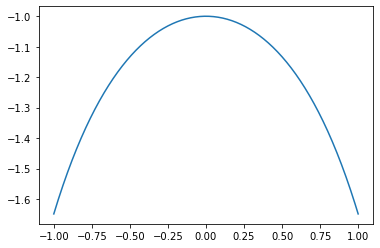

In [4]:
h = 1
x_points = np.linspace(-1,1,201)
pdf = np.empty([len(x_points),1])
for i in range(len(x_points)):
    dist = euclidian_distance(0, x_points[i])
    pdf[i] = gaussian_kernel(dist, h)
plt.plot(x_points,pdf)
plt.show()

Implement a function `MS_step` that takes as input a starting point `x`, a set of data points `data`, and a bandwidth `h` and returns the updated position of the point `x` after one step of the mean-shift algorithm.

In [5]:
def MS_step(X, h, radius, index):
    numerator = 0
    denominator = 0
    for i, x_i in enumerate(X):
        dist = euclidian_distance(X[index], x_i)
        if dist < radius:
            weight = gaussian_kernel(dist, h)
            numerator += weight * x_i
            denominator += weight
    return numerator / denominator

Implement the function `MS_point` which iterates `MS_step` until convergence (i.e., when the estimate changes by less than a small constant).

In [6]:
def MS_point(X):
    new_x = np.empty([X.shape[0],X.shape[1]])
    for j in range(len(X)):
        new_x[j,:] = MS_step(X, h, radius, j)
    rmse = np.sqrt(np.mean((X - new_x)**2))
    return new_x, rmse

Test it on your synthetic data and visualize the results.

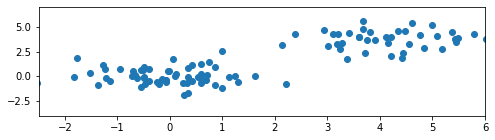

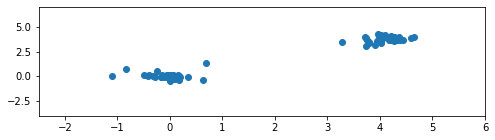

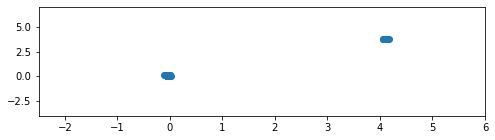

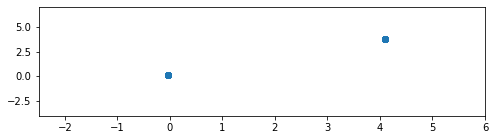

In [7]:
data = np.concatenate((x.reshape(-1,1),y.reshape(-1,1)),axis=1)
X = np.copy(data)
plt.figure(figsize=(8,2))
plt.plot(X[:,0],X[:,1],'o')
plt.xlim([-2.5,6])
plt.ylim([-4,7])

h = 1
radius = 2 
rmse = np.inf
while rmse > 0.1:
    new_x, rmse = MS_point(X)
    plt.figure(figsize=(8,2))
    plt.plot(new_x[:,0],new_x[:,1],'o')
    plt.xlim([-2.5,6])
    plt.ylim([-4,7])
    plt.show()
    X = new_x 

Implement the full mean shift algorithm by iterating `MS_point` on all the points, and merging modes for which distance is less than some constant. It should return a list of the modes and a label (corresponding to a mode) for each point.

In [8]:
def assign_labels(X,dist_constant):
    modes = []
    labels = []
    counter = 0
    for i in range(len(X)):
        if i == 0:
            modes.append(X[i])
            labels.append(counter)
            counter += 1
        else:
            dist = np.array([euclidian_distance(X[i],mode) for mode in modes])
            if len(np.argwhere(dist < dist_constant)) > 0:
                labels.append(np.argmin(dist))
            else:
                modes.append(X[i])
                labels.append(counter)
                counter += 1
    return np.array(labels), np.array(modes)

Visualize your results.

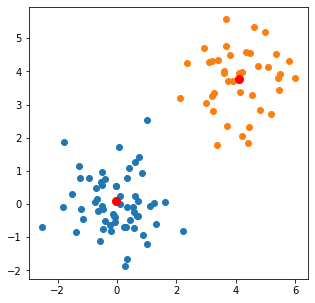

In [9]:
dist_constant = 0.1
labels, modes = assign_labels(X,dist_constant)
plt.figure(figsize=(5,5))
for i in range(len(np.unique(labels))):
    plt.plot(data[np.argwhere(labels==i),0],data[np.argwhere(labels==i),1],'o')
plt.plot(modes[:,0],modes[:,1],'o',markersize=8,color='r')
plt.show()

Modify the previous code by allowing for a "bandwidth vector" $h \in \mathbb R^d$ that defines a different scale for each dimension of the input (this is because for segmentation we will use a different bandwidth for space and color). Note that you should also modify the convergence and merging conditions to consider this non-isotropic scaling.

I decided to implement my version of the mean-shift algorithm so that it could handle data of any dimensionality, without having to account for non-isotropic scaling that would result from a single bandwidth scalar. This also means that I do not have to update any implementations for the convergence and merging conditions for each of the modes. To accomplish this - before running the algorithm on the data - I first normalized each column with respect to a range from 0 to 1. With this approach, one is able to compute the Euclidian distance between a given pair of points in any arbitrary n-dimensional space, returning a single scalar value, which is then used to compute the negative derivative of the Gaussian kernel. See the results below - it came out quite nicely for our small image represented in 5-dimensional space.

Experiment with your code by changing the data distribution, the kernel, and bandwidth vector.

Original image


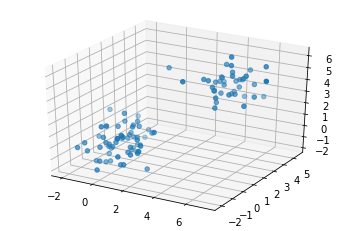

Mean-shift clustered image


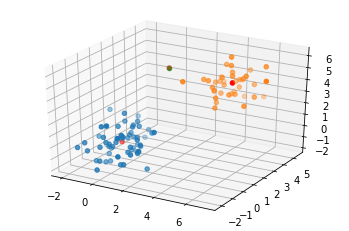

In [10]:
# Generate synthetic data:
x1 = np.random.normal(0,1,60)
y1 = np.random.normal(0,1,60)
z1 = np.random.normal(0,1,60)
x2 = np.random.normal(4,1,40)
y2 = np.random.normal(4,1,40)
z2 = np.random.normal(4,1,40)

# Concatenate the data:
x = np.concatenate((x1,x2))
y = np.concatenate((y1,y2))
z = np.concatenate((z1,z2))

# Plot the data:
data = np.concatenate((x.reshape(-1,1),y.reshape(-1,1),z.reshape(-1,1)),axis=1)
X = np.copy(data)
print('Original image')
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2])
plt.show()

# Run the algorithm:
h = 1
radius = 2 
rmse = np.inf
while rmse > 0.1:
    new_x, rmse = MS_point(X)
    X = new_x 

# Compute the modes:
dist_constant = 0.1
labels, modes = assign_labels(X,dist_constant)

# Plot the output:
print('Mean-shift clustered image')
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
for i in range(len(np.unique(labels))):
    ax.scatter(data[np.argwhere(labels==i),0], data[np.argwhere(labels==i),1], data[np.argwhere(labels==i),2])
ax.scatter(modes[:,0],modes[:,1],modes[:,2],color='r')
plt.show()

**Part 2: mean shift for image segmentation**

For image segmentation, we will use the "Lab" color space because it approximates the way humans perceive color better than RGB. Load the image `veggies_small.jpg` (download from <a href="https://drive.google.com/file/d/1mmzZaKOCsH6PEo4w6Y6plcgf-vbEJvoj/view?usp=sharing">here</a>), and convert it to the Lab colorspace using the command `rgb2lab`. What is the range of the colorvalues in Lab? 

(62, 50, 3)


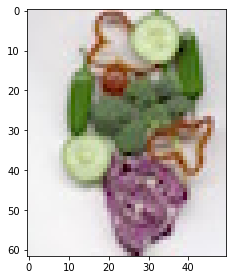

In [11]:
img = skimage.io.imread('veggies_small.jpg')
print(img.shape)
plt.figure(figsize=(4,4))
skimage.io.imshow(img)
plt.show()

Convert the (N,M,3) image into an (N,M,5) matrix incuding color and position information for each point (tip: use the `np.meshgrid` function). What do you think might be a good choice for a bandwidth vector $h$?

In [12]:
img = img/np.max(img)
height, width, depth = img.shape
x, y = np.meshgrid(range(width), range(height))
x, y = x/np.max(x), y/np.max(y)
test_img = np.concatenate([img, np.expand_dims(x, axis=2), np.expand_dims(y, axis=2)], axis=2)
test_img.shape

(62, 50, 5)

Use your mean shift code from the previous section to compute a meaningful segmentation of the image. Visualize the results as an image by replacing the color values of the pixels associated with each mode by the color of the mode.

In [13]:
X = test_img.reshape((test_img.shape[0]*test_img.shape[1]), test_img.shape[2])
X.shape

(3100, 5)

Number of modes: 69


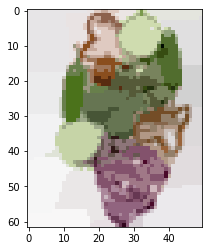

In [14]:
h = 1
radius = h/X.shape[1]
rmse = np.inf
while rmse > 0.1:
    new_x, rmse = MS_point(X)
    X = new_x 
labels, modes = assign_labels(X,radius)
print('Number of modes:', len(np.unique(labels)))

colors = modes[:,:3]
img_plot = np.empty([X[:,:3].shape[0],X[:,:3].shape[1]])
for i in range(len(labels)):
    img_plot[i,:] = colors[labels[i]]
img_plot = img_plot.reshape(img.shape[0],img.shape[1],img.shape[2])
plt.imshow(img_plot)
plt.show()

You can also try our algorithm on other (small) images.

(50, 50, 3)


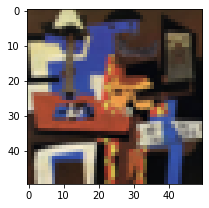

In [15]:
img = skimage.io.imread('three_musicians.png')
img = img[:,:,:3]
print(img.shape)
plt.figure(figsize=(3,3))
skimage.io.imshow(img)
plt.show()

In [16]:
img = img/np.max(img)
height, width, depth = img.shape
x, y = np.meshgrid(range(width), range(height))
x, y = x/np.max(x), y/np.max(y)
test_img = np.concatenate([img, np.expand_dims(x, axis=2), np.expand_dims(y, axis=2)], axis=2)
test_img.shape

(50, 50, 5)

In [17]:
X = test_img.reshape((test_img.shape[0]*test_img.shape[1]), test_img.shape[2])
X.shape

(2500, 5)

Number of modes: 106


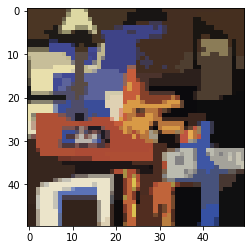

In [18]:
h = 1
radius = h/X.shape[1]
rmse = np.inf
while rmse > 0.1:
    new_x, rmse = MS_point(X)
    X = new_x 
labels, modes = assign_labels(X,radius)
print('Number of modes:', len(np.unique(labels)))

colors = modes[:,:3]
img_plot = np.empty([X[:,:3].shape[0],X[:,:3].shape[1]])
for i in range(len(labels)):
    img_plot[i,:] = colors[labels[i]]
img_plot = img_plot.reshape(img.shape[0],img.shape[1],img.shape[2])
plt.imshow(img_plot)
plt.show()